# Multivariate Gaussian Mixture Model
The multivariate Gaussian Mixture Model can be represented as:
$$
\begin{align*}
    p(\mathbf{s})   &= \mathrm{Dir}(\mathbf{s}|\boldsymbol{\alpha}) \\
    p(\mathbf{m}_{l}) &=  \mathcal{N}(m_l|\boldsymbol{\mu}_l, \boldsymbol{\Sigma}_l) \\    
    p(\mathbf{W}_{l}) &=  \mathcal{W}(\mathbf{W}_l|\mathbf{V}_l, \nu_l) \\
    p(\mathbf{z}_i) &=  \mathrm{Cat}(\mathbf{z}_i|\mathbf{s}) \\
    p(\mathbf{y}_i) &= \prod_{l=1}^L \mathcal{N}\left(\mathbf{m}_{l}, \mathbf{W}_{l}\right)^{\mathbf{z}_{i}}
\end{align*}
$$

In [1]:
ENV["GKS_ENCODING"]="utf8"

using Rocket, ReactiveMP, GraphPPL
using Distributions, Plots
using Random, LinearAlgebra, BenchmarkTools

In [14]:
Random.seed!(125)

L         = 50.0
nmixtures = 4
n_samples = 500

probvec = ones(nmixtures)
probvec = probvec ./ sum(probvec)

switch = Categorical(probvec)

println("Switch distribution: ", Distributions.params(switch))

gaussians = map(1:nmixtures) do index
    angle      = 2π / nmixtures * (index - 1)
    basis_v    = L * [ 1.0, 0.0 ]
    rotationm  = [ cos(angle) -sin(angle); sin(angle) cos(angle) ]
    mean       = rotationm * basis_v 
    covariance = Matrix(Hermitian(rotationm * [ 10.0 0.0; 0.0 20.0 ] * transpose(rotationm)))
    return MvNormal(mean, covariance)
end

z = rand(switch, n_samples)
y = Vector{Vector{Float64}}(undef, n_samples)

for i in 1:n_samples
    y[i] = rand(gaussians[z[i]])
end

Switch distribution: ([0.25, 0.25, 0.25, 0.25],)


In [15]:
sdim(n) = (a) -> map(d -> d[n], a)

sdim (generic function with 1 method)

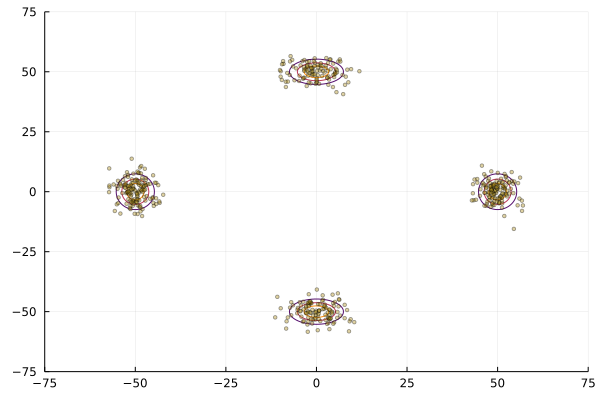

In [16]:
p = plot(xlim = (-1.5L, 1.5L), ylim = (-1.5L, 1.5L))

for (index, gaussian) in enumerate(gaussians)
    p = contour!(p, range(-2L, 2L, step = 0.25), range(-2L, 2L, step = 0.25), (x, y) -> pdf(gaussian, [ x, y ]), levels = 3, colorbar = false)
end

p = scatter!(y |> sdim(1), y |> sdim(2), ms = 2, alpha = 0.4)

plot(p, size = (600, 400), legend=false)

In [17]:
@model [ default_factorisation = MeanField() ] function gaussian_mixture_model(rng, nmixtures, n, priors_mean, priors_cov)
    
    z = randomvar(n)
    m = randomvar(nmixtures)
    w = randomvar(nmixtures)
    
    basis_v = [ 1.0, 0.0 ]
    
    for i in 1:nmixtures        
        m[i] ~ MvNormalMeanCovariance(priors_mean[i], priors_cov[i])
        w[i] ~ Wishart(3, [ 1e2 0.0; 0.0 1e2 ])
    end
    
    s ~ Dirichlet(ones(nmixtures))

    y = datavar(Vector{Float64}, n)
    
    means = tuple(m...)
    precs = tuple(w...)
    
    for i in 1:n
        z[i] ~ Categorical(s) 
        y[i] ~ NormalMixture(z[i], means, precs)
    end
    
    return s, z, m, w, y
end

In [24]:
rng = MersenneTwister(11)

basis_v       = [ 1.0, 0.0 ]
approximate_L = 50rand(rng)
priors_mean   = []

for i in 1:nmixtures
    approximate_angle_prior = ((2π + rand(rng)) / nmixtures) * (i - 1)
    approximate_basis_v  = approximate_L / 2 * (basis_v .+ rand(rng, 2))
    approximate_rotation = [ cos(approximate_angle_prior) -sin(approximate_angle_prior); sin(approximate_angle_prior) cos(approximate_angle_prior) ]
    push!(priors_mean,  approximate_rotation * approximate_basis_v)
end

priors_cov = [ [ 1e6 0.0; 0.0 1e6 ] for _ in 1:nmixtures ]

initmarginals = (
    s = vague(Dirichlet, nmixtures), 
    m = [ MvNormalMeanCovariance(prior[1], prior[2]) for prior in zip(priors_mean, priors_cov) ], 
    w = Wishart(3, [ 1e2 0.0; 0.0 1e2 ])
)

result = inference(
    model = Model(gaussian_mixture_model, rng, nmixtures, length(y), priors_mean, priors_cov), 
    data  = (y = y,), 
    initmarginals = initmarginals, 
    iterations  = 10, 
    free_energy = true
)

Inference results:
-----------------------------------------
Free Energy: Real[5039.81, 4353.65, 3872.99, 3626.1, 3623.77, 3623.77, 3623.77, 3623.77, 3623.77, 3623.77]
-----------------------------------------
m = Vector{MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}}...
w = Vector{Wishart{Float64, PDMats.PDMat{Float64, Matrix{Float64}}, Int64}}[[Wishart...
s = Dirichlet{Float64, Vector{Float64}, Float64}[Dirichlet{Float64, Vector{Float64},...
z = Vector{Categorical{Float64, Vector{Float64}}}[[Categorical{Float64, Vector{Float...


In [25]:
s = result.posteriors[:s]
z = result.posteriors[:z]
m = result.posteriors[:m]
w = result.posteriors[:w]
fe = result.free_energy;

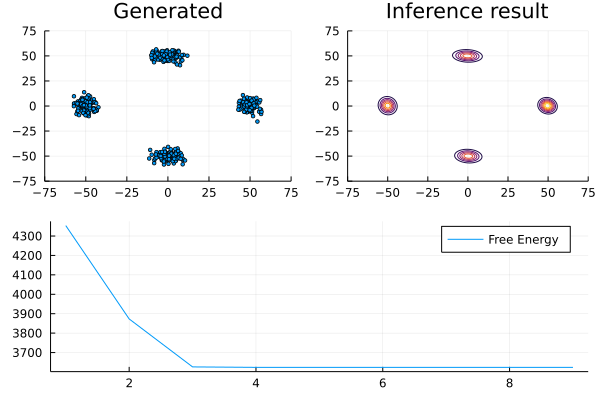

In [26]:
pe = plot(xlim = (-1.5L, 1.5L), ylim = (-1.5L, 1.5L))

rp = scatter(y |> sdim(1), y |> sdim(2), xlim = (-1.5L, 1.5L), ylim = (-1.5L, 1.5L), legend=false, title="Generated", ms = 2)

e_means = mean.(m[end])
e_covs  = mean.(inv, w[end])

for (e_m, e_c) in zip(e_means, e_covs)
    gaussian = MvNormal(e_m, Matrix(Hermitian(e_c)))
    pe = contour!(pe, range(-2L, 2L, step = 0.25), range(-2L, 2L, step = 0.25), (x, y) -> pdf(gaussian, [ x, y ]), title="Inference result", legend=false, levels = 7, colorbar = false)
end

pfe = plot(fe[2:end], label = "Free Energy")

plot(rp, pe, pfe, layout = @layout([ a b; c ]))

In [28]:
@benchmark inference(
    model = $(Model(gaussian_mixture_model, rng, nmixtures, length(y), priors_mean, priors_cov)), 
    data = $((y = y,)), 
    initmarginals = $initmarginals, 
    iterations = 10, 
    free_energy = true
)

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  222.769 ms … 297.828 ms  ┊ GC (min … max):  0.00% … 25.32%
 Time  (median):     275.474 ms               ┊ GC (median):    18.72%
 Time  (mean ± σ):   260.938 ms ±  29.425 ms  ┊ GC (mean ± σ):  14.10% ± 11.00%

  █  ▃ ▃                                    ▃    ▃            ▃  
  █▁▁█▁█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁█▇▁▁▁█▇▁▇▁▇▁▁▁▁▇▁▁█ ▁
  223 ms           Histogram: frequency by time          298 ms <

 Memory estimate: 172.89 MiB, allocs estimate: 2010785.